<a href="https://colab.research.google.com/github/itspopoy57/Machinelearning/blob/main/04_Transfer_Learning_P1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer Learning

ctrl+ shift + space ==> docstring

imagenet dataset

In [1]:
#are we using a gpu?
!nvidia-smi
#  0  Tesla T4

Mon Oct 30 19:48:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##be one with the data

In [2]:
#download the data
#get data 10% of 10 food classes from food 101
import zipfile
#download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

#unzuip
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-10-30 19:48:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.196.207, 173.194.197.207, 142.251.171.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.196.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   144MB/s    in 1.1s    

2023-10-30 19:48:57 (144 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
import os
#walkthrough 10 percent data directory

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"there are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

there are 2 directories and 0 images in '10_food_classes_10_percent'.
there are 10 directories and 0 images in '10_food_classes_10_percent/test'.
there are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
there are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
there are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
there are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
there are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
there are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
there are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
there are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
there are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
there are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

In [4]:
#preparing the data
#we are using the imagedatagenerator to laod the images into batches

#setup data inputs

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#CAPITAL ALL MEANS HYPER PARAMETERS
IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

#training the datagen images
print("training images: ")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode = "categorical")

print("Testing images")
test_data = test_datagen.flow_from_directory(test_dir,
                                                        target_size = IMAGE_SHAPE,
                                                        batch_size= BATCH_SIZE,
                                                        class_mode = "categorical")



training images: 
Found 750 images belonging to 10 classes.
Testing images
Found 2500 images belonging to 10 classes.


In [5]:
##introducing callbacks
####key role for the future
##things to run while our model trains


#are extra functionality to add on our models
#to be performed before or after training

##popular callbacks

##tracking experiments with --- TensorBoard callback
##Model checkpoint with --- ModelCheckpoint callback
##stopping a model from training --- EarlyStopping callback

## there are alot of callbacks but these 3 are the most popular


In [6]:
####lets make a tensor board callbacks
  ###to keep track of the experiment
  ### we making it function because we need it to each model we create

In [7]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving tensorboard log files to: {log_dir}")
  return tensorboard_callback


#tensorflow hub pre trained model!

In [8]:
################# tfhub.dev
##tensorhub is like huggingman its pretrainned models

##papers withcode.com is the one we can use to see the most reliable and recent
#sample https://paperswithcode.com/task/image-classification
##
##
##browsing the tensorflow hb page and sorting for image classification
##https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [9]:
#lets compare resnet and efficientnet
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [10]:
#import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [13]:
## lets make a create_model func to create model from url
def create_model(model_url, num_classes=10):
  """
  Takes a Tensorflow Hub URL and creates a Keras Sequesntial model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
    should be equal to number of target classes, default 10.

  returns :
    an uncompiled keras sequentiual model with model_url as feature extractor
    layer and dense output layer with num_classes output neurons.
  """
  #Download the pretrained model and save it as a keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="Feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))

  ##creating our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

##creating Resnet TensorFlow Hub Feature Extraction Model

In [14]:
###########Create Resnet Model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [16]:
#compile resnet model
resnet_model.compile(loss=tf.keras.losses.categorical_crossentropy,
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])


In [22]:
resnet_history = resnet_model.fit(train_data_10_percent, epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                          experiment_name="resnet50V2")])



Saving tensorboard log files to: tensorflow_hub/resnet50V2/20231030-200303
Epoch 1/5
24/24 [==============================] - 26s 563ms/step - loss: 1.8232 - accuracy: 0.3947 - val_loss: 1.1585 - val_accuracy: 0.6456
Epoch 2/5
24/24 [==============================] - 11s 485ms/step - loss: 0.8642 - accuracy: 0.7533 - val_loss: 0.8439 - val_accuracy: 0.7268
Epoch 3/5
24/24 [==============================] - 12s 524ms/step - loss: 0.6049 - accuracy: 0.8387 - val_loss: 0.7470 - val_accuracy: 0.7572
Epoch 4/5
24/24 [==============================] - 12s 500ms/step - loss: 0.4659 - accuracy: 0.8800 - val_loss: 0.6964 - val_accuracy: 0.7752
Epoch 5/5
24/24 [==============================] - 12s 504ms/step - loss: 0.3792 - accuracy: 0.9120 - val_loss: 0.6904 - val_accuracy: 0.7756


In [15]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


##better val_accuracy on the transfer learning technique

In [23]:
import matplotlib.pyplot as plt

def plot_loss_curve(history):
  """
  returns separate loss curves for training and validation

  args:
    History: tensorflow history Object

  Returns:
    Plots of Training/Validation loss and accuracy metrics.

    """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  #plot loss
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("epochs")
  plt.legend()

  #plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_loss, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()



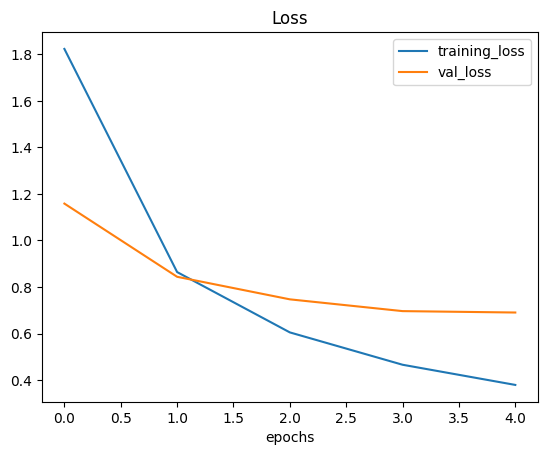

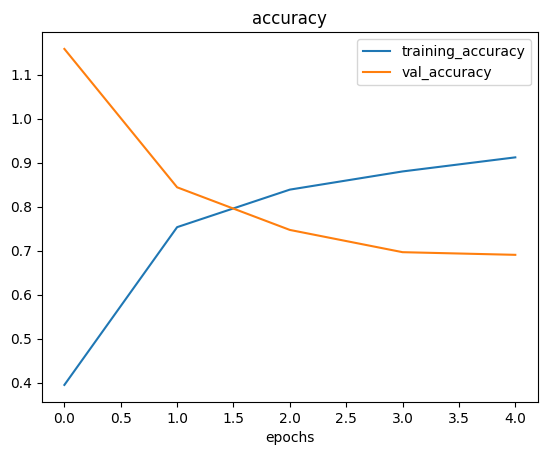

In [24]:
plot_loss_curve(resnet_history)

##creating efficient netb0 TensorFlow Hub Feature Extraction Model

In [28]:
from keras.src.engine.training import optimizer
efficientnet_model = create_model(efficientnet_url,
                            num_classes=train_data_10_percent.num_classes)

efficientnet_model.compile(loss=tf.keras.losses.categorical_crossentropy,
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

In [29]:
history_efficientnet = efficientnet_model.fit(train_data_10_percent, epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                          experiment_name="Efficientnet")])

Saving tensorboard log files to: tensorflow_hub/Efficientnet/20231030-202133
Epoch 1/5
24/24 [==============================] - 28s 669ms/step - loss: 1.9366 - accuracy: 0.3867 - val_loss: 1.3645 - val_accuracy: 0.6972
Epoch 2/5
24/24 [==============================] - 11s 457ms/step - loss: 1.1013 - accuracy: 0.7627 - val_loss: 0.8971 - val_accuracy: 0.8140
Epoch 3/5
24/24 [==============================] - 13s 576ms/step - loss: 0.7715 - accuracy: 0.8347 - val_loss: 0.7149 - val_accuracy: 0.8400
Epoch 4/5
24/24 [==============================] - 13s 551ms/step - loss: 0.6176 - accuracy: 0.8667 - val_loss: 0.6216 - val_accuracy: 0.8524
Epoch 5/5
24/24 [==============================] - 13s 552ms/step - loss: 0.5216 - accuracy: 0.8840 - val_loss: 0.5642 - val_accuracy: 0.8608


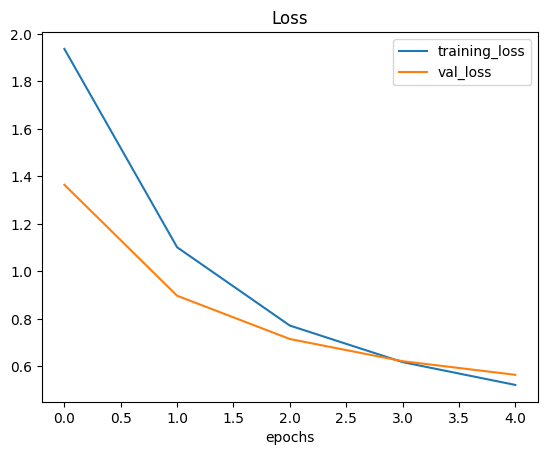

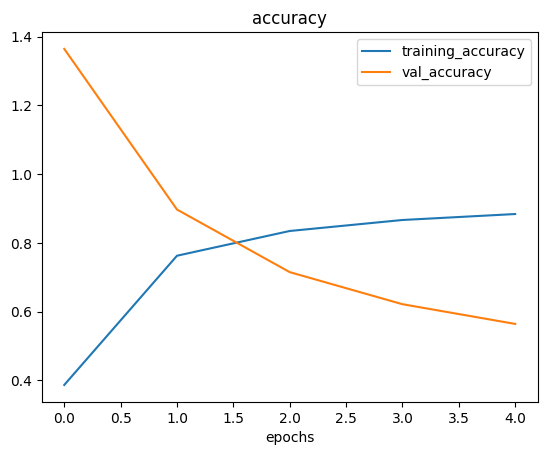

In [30]:
plot_loss_curve(history_efficientnet)

In [31]:
resnet_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [32]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


##different types of transfer learning

as is -- transfer learning using an existing model with no changes what so ever

feature extraction transfer learning -- use the prelearned partters of an existinf model

fine-tuning transfer learning -- use the prelearned patterns of but including new output laters